In [2]:
import numpy as np
import pandas as pd
from itertools import combinations
from multiprocessing import Pool, cpu_count

# Load and preprocess data
df_close = pd.read_csv("HISTORICAL PRICES - Sheet1-2.csv")
df_close['Date'] = pd.to_datetime(df_close['Date'])
df_close.set_index('Date', inplace=True)

# Exclude specific columns
columns_to_exclude = ['SBI', 'HDFL', 'HALC', 'PGRD']
filtered_columns = [col for col in df_close.columns if col not in columns_to_exclude]

for column in filtered_columns:
    df_close[column] = df_close[column].str.replace(',', '', regex=True)
    df_close[column] = df_close[column].str.replace('%', '', regex=True)
    df_close[column] = pd.to_numeric(df_close[column], errors='coerce').fillna(0)

df_close = df_close.sort_index(ascending=True)
log_returns = np.log(1 + df_close.pct_change()).dropna()

# Portfolio parameters
portfolio_size = 5
all_combinations = list(combinations(log_returns.columns, portfolio_size))
risk_free_rate = 0.07365
num_iterations = 1000

# Function to simulate portfolio
def simulate_portfolio(combination):
    subset = log_returns[list(combination)]
    num_stocks = subset.shape[1]

    weights_array = np.random.dirichlet(np.ones(num_stocks), num_iterations)
    exp_returns = np.dot(weights_array, subset.mean() * 252)
    cov_matrix = subset.cov() * 252
    vol_array = np.sqrt(np.einsum('ij,ij->i', np.dot(weights_array, cov_matrix), weights_array))
    sharpe_array = (exp_returns - risk_free_rate) / vol_array

    max_sharpe_idx = sharpe_array.argmax()
    min_vol_idx = vol_array.argmin()
    max_return_idx = exp_returns.argmax()

    return {
        'Combination': combination,
        'Max Sharpe': sharpe_array[max_sharpe_idx],
        'Max Sharpe Weights': weights_array[max_sharpe_idx],
        'Min Volatility': vol_array[min_vol_idx],
        'Min Volatility Weights': weights_array[min_vol_idx],
        'Max Return': exp_returns[max_return_idx],
        'Max Return Weights': weights_array[max_return_idx]
    }

# Use multiprocessing to speed up the simulation
if __name__ == '__main__':
    with Pool(cpu_count()) as pool:
        results_list = pool.map(simulate_portfolio, all_combinations)

    results_df = pd.DataFrame(results_list)

    # Find the best portfolios across all combinations
    best_sharpe_portfolio = results_df.loc[results_df['Max Sharpe'].idxmax()]
    best_volatility_portfolio = results_df.loc[results_df['Min Volatility'].idxmin()]
    best_return_portfolio = results_df.loc[results_df['Max Return'].idxmax()]

    # Output the results
    print("Best Portfolio Based on Max Sharpe Ratio:")
    print(best_sharpe_portfolio)

    print("\nBest Portfolio Based on Min Volatility:")
    print(best_volatility_portfolio)

    print("\nBest Portfolio Based on Max Return:")
    print(best_return_portfolio)


<ipython-input-2-d5f2cb72e5eb>:8: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_close['Date'] = pd.to_datetime(df_close['Date'])


Best Portfolio Based on Max Sharpe Ratio:
Combination                                   (CUMM, TVSM, PGRD, THMX, ABB)
Max Sharpe                                                         1.222519
Max Sharpe Weights        [0.32810086152195567, 0.21304676982611076, 0.1...
Min Volatility                                                      0.19376
Min Volatility Weights    [0.14449541814949798, 0.24588720591686658, 0.3...
Max Return                                                          0.36226
Max Return Weights        [0.6964274598008342, 0.09788252165772732, 0.00...
Name: 1812, dtype: object

Best Portfolio Based on Min Volatility:
Combination                                     (TCS, HLL, PGRD, THMX, ABB)
Max Sharpe                                                         0.989298
Max Sharpe Weights        [0.08905190717264956, 0.0023136992069336198, 0...
Min Volatility                                                     0.155531
Min Volatility Weights    [0.25374159278903097, 0.31646

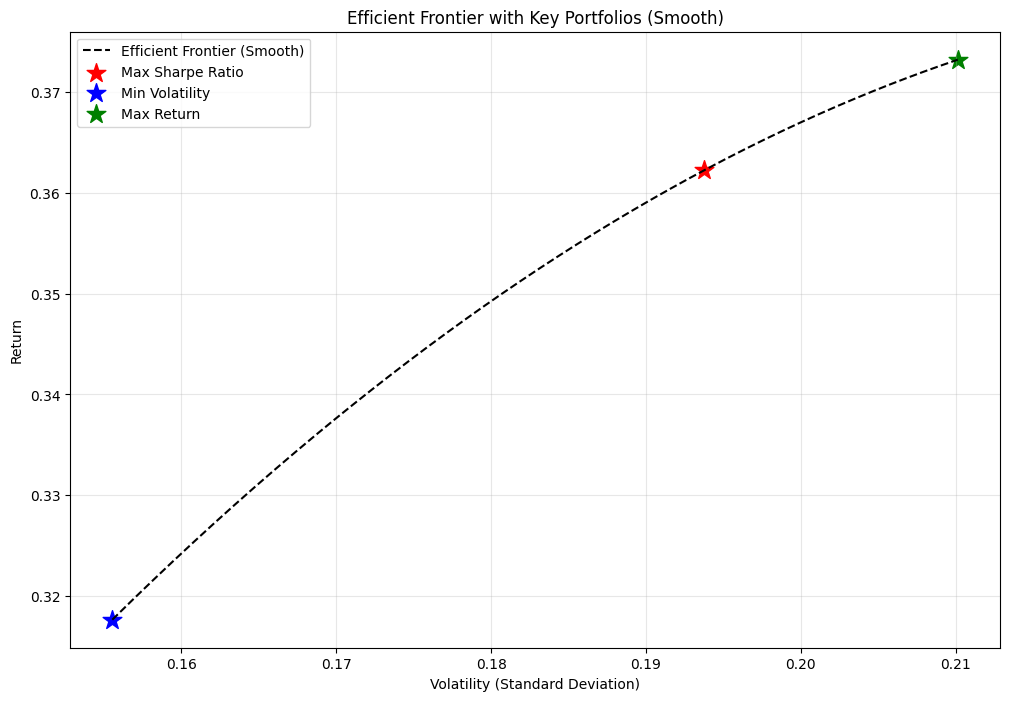

In [5]:

import matplotlib.pyplot as plt

# Plotting the Smooth Efficient Frontier with Key Portfolios
def plot_smooth_efficient_frontier(results_df):
    # Extract data for the three key portfolios
    vol_array = [
        best_sharpe_portfolio['Min Volatility'],
        best_volatility_portfolio['Min Volatility'],
        best_return_portfolio['Min Volatility']
    ]
    ret_array = [
        best_sharpe_portfolio['Max Return'],
        best_volatility_portfolio['Max Return'],
        best_return_portfolio['Max Return']
    ]

    # Generate additional points for a smooth curve
    sorted_indices = np.argsort(vol_array)
    vol_array = np.array(vol_array)[sorted_indices]
    ret_array = np.array(ret_array)[sorted_indices]

    # Interpolation for a smooth curve
    from scipy.interpolate import interp1d
    interpolator = interp1d(vol_array, ret_array, kind='quadratic')
    smooth_volatility = np.linspace(vol_array[0], vol_array[-1], 500)
    smooth_return = interpolator(smooth_volatility)

    # Plot the efficient frontier
    plt.figure(figsize=(12, 8))
    plt.plot(smooth_volatility, smooth_return, 'k--', label='Efficient Frontier (Smooth)')

    # Highlight the key portfolios
    plt.scatter(best_sharpe_portfolio['Min Volatility'], best_sharpe_portfolio['Max Return'],
                c='red', marker='*', s=200, label='Max Sharpe Ratio')
    plt.scatter(best_volatility_portfolio['Min Volatility'], best_volatility_portfolio['Max Return'],
                c='blue', marker='*', s=200, label='Min Volatility')
    plt.scatter(best_return_portfolio['Min Volatility'], best_return_portfolio['Max Return'],
                c='green', marker='*', s=200, label='Max Return')

    # Configure the plot
    plt.title('Efficient Frontier with Key Portfolios (Smooth)')
    plt.xlabel('Volatility (Standard Deviation)')
    plt.ylabel('Return')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.show()

# Call the function
plot_smooth_efficient_frontier(results_df)


In [ ]:
df_close

CUMM     INFY      TCS     HDBK     ICBK     KTKM     LART     SBI      HLL    HDFL    HALC     TVSM     LTEH    PGRD     THMX     KAJR      ABB
Date                                                                                                                                                           
2019-11-29   542.25   696.35  2053.25  1274.95   512.60  1615.20  1330.55  338.50  2035.30  571.50  200.15   477.25  1490.75  106.10  1026.70   536.05  1447.80
2019-12-02   539.70   692.70  2021.05  1265.75   510.90  1633.00  1333.35  336.25  2043.20  569.40  200.80   467.75  1471.95  104.99  1008.10   522.05  1479.40
2019-12-03   532.75   698.35  2051.00  1255.40   509.35  1646.75  1313.20  341.85  2028.45  584.75  196.00   455.35  1463.45  104.44   999.90   513.40  1460.70
2019-12-04   537.65   708.85  2078.50  1251.65   529.25  1651.25  1285.10  336.20  2048.00  583.65  201.10   451.55  1482.50  103.83   982.35   515.15  1449.70
2019-12-05   539.35   714.85  2121.30  1245.60   528.10  1649.30  1302.20  320.00  2037.45  575.90  198.55   452.20  1488.20  103.44   991.15   516.60  1440.15
...             ...      ...      ...      ...      ...      ...      ...     ...      ...     ...     ...      ...      ...     ...      ...      ...      ...
2024-11-25  3535.85  1889.70  4315.10  1785.60  1300.95  1790.75  3753.00  844.45  2471.45  684.80  659.85  2458.35  5458.15  342.75  4448.55  1227.60  7259.85
2024-11-26  3463.20  1924.15  4352.70  1785.55  1304.95  1783.60  3702.60  839.40  2479.20  682.40  666.10  2424.60  5489.70  338.80  4633.95  1222.50  7329.70
2024-11-27  3500.70  1924.50  4332.55  1812.30  1300.70  1783.20  3698.70  834.10  2486.90  680.55  661.10  2440.65  5431.20  339.25  4611.35  1224.90  7496.20
2024-11-28  3481.25  1856.65  4244.90  1793.15  1286.35  1759.20  3666.05  838.85  2462.20  657.70  650.25  2415.45  5249.65  333.65  4575.00  1209.05  7394.85
2024-11-29  3483.70  1857.85  4270.85  1796.05  1300.10  1765.25  3724.80  838.95  2496.15  657.75  656.20  2434.45  5285.20  329.40  4590.10  1206.90  7421.25

[1243 rows x 17 columns]